# Simple AutoML for time series with Ray AIR

In [ ]:
!pip install statsforecast

In [2]:
from typing import List, Union, Callable, Dict, Type, Tuple
import time
import itertools
import pandas as pd
import numpy as np
from collections import defaultdict
from statsforecast import StatsForecast
from statsforecast.models import ETS, AutoARIMA, _TS
from pyarrow import parquet as pq
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import ray
from ray import air, tune
from ray.air import Checkpoint, session

In [3]:
if ray.is_initialized():
    ray.shutdown()
ray.init(runtime_env={"pip": ["statsforecast"]})

2022-10-24 17:23:58,620	INFO worker.py:1229 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2022-10-24 17:24:00,588	INFO worker.py:1341 -- Connecting to existing Ray cluster at address: 172.31.107.241:9031...
2022-10-24 17:24:00,599	INFO worker.py:1518 -- Connected to Ray cluster. View the dashboard at https://console.anyscale-staging.com/api/v2/sessions/ses_J737nkSmzssxqHpQ2RQREEaP/services?redirect_to=dashboard 
2022-10-24 17:24:01,491	INFO packaging.py:354 -- Pushing file package 'gcs://_ray_pkg_1d323f2ab36ecc833c96c5233c76f90d.zip' (102.96MiB) to Ray cluster...
2022-10-24 17:24:02,964	INFO packaging.py:367 -- Successfully pushed file package 'gcs://_ray_pkg_1d323f2ab36ecc833c96c5233c76f90d.zip'.


Python version:,3.8.13
Ray version:,3.0.0.dev0
Dashboard:,http://console.anyscale-staging.com/api/v2/sessions/ses_J737nkSmzssxqHpQ2RQREEaP/services?redirect_to=dashboard


## Read the dataset from S3 using `ray.data`

In [4]:
import pyarrow as pa
from pyarrow.dataset import field

def transform_ds(batch: pd.DataFrame) -> pd.DataFrame:
    # StatsForecasts expects specific column names!
    batch = batch.rename(
        columns={"item_id": "unique_id", "timestamp": "ds", "demand": "y"}
    )
    batch["unique_id"] = batch["unique_id"].astype(str)
    batch["ds"] = pd.to_datetime(batch["ds"])
    batch = batch.dropna()
    constant = 10
    batch["y"] += constant
    return batch

# Only consider a single time series for this example.
partition_ids = ["FOODS_1_001_CA_1"]

ds = ray.data.read_parquet(
    "s3://anonymous@m5-benchmarks/data/train/target.parquet",
    columns=["item_id", "timestamp", "demand"],
    filter=field("item_id").isin(partition_ids)
).map_batches(transform_ds, batch_format="pandas")

train_df = ds.to_pandas()

Parquet Files Sample:   0%|          | 0/1 [00:00<?, ?it/s]
2022-10-24 17:24:12,004	WARNING read_api.py:296 -- ⚠️  The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Read->Map_Batches: 100%|██████████| 1/1 [00:09<00:00,  9.92s/it]


## Create the training function

We will define a custom training loop that performs temporal cross-validation on the dataset and reports the mean prediction error. We will run this training loop on all the model types and model parameters we are searching over, and the model that produces the lowest error will be the output of this AutoML example.

In [5]:
def train_func(config, Y_train_df=None):
    assert Y_train_df is not None, "Must pass in dataset"
    model_cls, model_params = config.get("model_cls_and_params")
    freq = config.get("freq")
    metrics = config.get("metrics", {"mse": mean_squared_error})

    # CV params
    test_size = config.get("test_size", None)
    n_splits = config.get("n_splits", 5)

    model = model_cls(**model_params)

    # Default the parallelism to the # of cross-validation splits
    parallelism_kwargs = {"ray_address": "auto", "n_jobs": n_splits}
    
    # Initialize statsforecast with the model, using Ray as its parallel backend
    statsforecast = StatsForecast(
        df=Y_train_df,
        models=[model],
        freq=freq,
        **parallelism_kwargs,
    )

    test_size = test_size or len(Y_train_df) // (n_splits + 1)
    start_time = time.time()
    forecasts_cv = statsforecast.cross_validation(
        h=test_size,
        n_windows=n_splits,
        step_size=test_size,
    )
    cv_time = time.time() - start_time

    # Compute metrics (according to `metrics`)
    cv_results = compute_metrics_and_aggregate(forecasts_cv, model, metrics)

    # Report metrics to Tune
    results = {
        **cv_results,
        "cv_time": cv_time,
    }
    checkpoint_dict = {
        "cross_validation_df": forecasts_cv,
    }
    checkpoint = Checkpoint.from_dict(checkpoint_dict)
    session.report(results, checkpoint=checkpoint)

We also define a helper function used above in the training function, which calculates the metrics from the dataframe output of the cross-validation.

In [6]:
def compute_metrics_and_aggregate(forecasts_cv, model, metrics):
    # unique_id values are the index of the forecasts dataframe
    unique_ids = forecasts_cv.index.unique()

    cv_aggregates = {}
    for unique_id in unique_ids:
        # If there's only one series in the dataset, we can just report
        # a single metric (without the unique_id in the metric prefix)
        prefix = f"{unique_id}/" if len(unique_ids) > 1 else ""
        # Calculate metrics separately for each series
        forecasts_for_id = forecasts_cv[forecasts_cv.index == unique_id]
        cutoff_values = forecasts_for_id["cutoff"].unique()

        # Calculate metrics of the predictions of the models fit on
        # each training split
        cv_metrics = defaultdict(list)
        for ct in cutoff_values:
            # Get CV metrics for a specific training window
            # All forecasts made with the same `cutoff` date
            window_df = forecasts_for_id[forecasts_for_id["cutoff"] == ct]
            for metric_name, metric_fn in metrics.items():
                cv_metrics[metric_name].append(
                    metric_fn(
                        window_df["y"], window_df[model.__class__.__name__]
                    )
                )

        # Calculate aggregated metrics (mean, std) across training splits
        for metric_name, metric_vals in cv_metrics.items():
            try:
                cv_aggregates[f"{prefix}{metric_name}_mean"] = np.nanmean(
                    metric_vals
                )
                cv_aggregates[f"{prefix}{metric_name}_std"] = np.nanstd(
                    metric_vals
                )
            except Exception as e:
                cv_aggregates[f"{prefix}{metric_name}_mean"] = np.nan
                cv_aggregates[f"{prefix}{metric_name}_std"] = np.nan

    return {
        "unique_ids": list(unique_ids),
        **cv_aggregates,
        "cutoff_values": cutoff_values,
    }

## Define the search space

In [7]:
search_space = {
    AutoARIMA: {},
    ETS: {
        "season_length": [6, 7],
        "model": ["ZNA", "ZZZ"],
    }
}

def generate_configurations(search_space):
    for model, params in search_space.items():
        if not params:
            yield model, {}
        else:
            configurations = itertools.product(*params.values())
            for config in configurations:
                config_dict = {k: v for k, v in zip(params.keys(), config)}
                yield model, config_dict

configs = list(generate_configurations(search_space))

## Create a Tuner and specify a grid search

In [8]:
tuner = tune.Tuner(
    tune.with_parameters(train_func, Y_train_df=train_df),
    param_space={
        "model_cls_and_params": tune.grid_search(configs),
        "n_splits": 5,
        "test_size": 1,
        "freq": "D",
    },
    tune_config=tune.TuneConfig(
        metric="mse_mean",
        mode="min",
    ),
)
result_grid = tuner.fit()

Trial name,cutoff_values,cv_time,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,mse_mean,mse_std,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,unique_ids,warmup_time
train_func_5f63f_00000,['2016-05-17T00:00:00.000000000' '2016-05-18T00:00:00.000000000' '2016-05-19T00:00:00.000000000' '2016-05-20T00:00:00.000000000' '2016-05-21T00:00:00.000000000'],16.7108,2022-10-24_17-24-42,True,,fb2ed2f992eb466b8d9532297c086d19,0_model_cls_and_params=class_statsforecast_models_AutoARIMA,ip-172-31-107-241,1,0.658737,0.336924,172.31.107.241,31032,True,16.7265,16.7265,16.7265,1666657482,0,,1,5f63f_00000,['FOODS_1_001_CA_1'],0.00336599
train_func_5f63f_00001,['2016-05-17T00:00:00.000000000' '2016-05-18T00:00:00.000000000' '2016-05-19T00:00:00.000000000' '2016-05-20T00:00:00.000000000' '2016-05-21T00:00:00.000000000'],22.7883,2022-10-24_17-24-52,True,,5750be2fc9714649a6c143f4bf144168,1_model_cls_and_params=class_statsforecast_models_ETS_season_length_6_model_ZNA,ip-172-31-107-241,1,0.642052,0.343518,172.31.107.241,31078,True,22.8035,22.8035,22.8035,1666657492,0,,1,5f63f_00001,['FOODS_1_001_CA_1'],0.00382829
train_func_5f63f_00002,['2016-05-17T00:00:00.000000000' '2016-05-18T00:00:00.000000000' '2016-05-19T00:00:00.000000000' '2016-05-20T00:00:00.000000000' '2016-05-21T00:00:00.000000000'],38.7562,2022-10-24_17-25-07,True,,5f9e0bb05f9947519b88ab0848807b6c,2_model_cls_and_params=class_statsforecast_models_ETS_season_length_6_model_ZZZ,ip-172-31-107-241,1,0.655225,0.335512,172.31.107.241,31079,True,38.7706,38.7706,38.7706,1666657507,0,,1,5f63f_00002,['FOODS_1_001_CA_1'],0.00367117
train_func_5f63f_00003,['2016-05-17T00:00:00.000000000' '2016-05-18T00:00:00.000000000' '2016-05-19T00:00:00.000000000' '2016-05-20T00:00:00.000000000' '2016-05-21T00:00:00.000000000'],22.9814,2022-10-24_17-24-52,True,,1dc04a8ab62f49b99b1398a0c4730919,3_model_cls_and_params=class_statsforecast_models_ETS_season_length_7_model_ZNA,ip-172-31-107-241,1,0.856209,0.431858,172.31.107.241,31081,True,22.9954,22.9954,22.9954,1666657492,0,,1,5f63f_00003,['FOODS_1_001_CA_1'],0.00388217
train_func_5f63f_00004,['2016-05-17T00:00:00.000000000' '2016-05-18T00:00:00.000000000' '2016-05-19T00:00:00.000000000' '2016-05-20T00:00:00.000000000' '2016-05-21T00:00:00.000000000'],40.1044,2022-10-24_17-25-09,True,,d5d620ea129d4c4aafd8b127211bc96e,4_model_cls_and_params=class_statsforecast_models_ETS_season_length_7_model_ZZZ,ip-172-31-107-241,1,0.859367,0.43596,172.31.107.241,31080,True,40.1216,40.1216,40.1216,1666657509,0,,1,5f63f_00004,['FOODS_1_001_CA_1'],0.00433207


2022-10-24 17:24:42,662	WARNING tensorboardx.py:224 -- You are trying to log an invalid value (ray/tune/unique_ids=['FOODS_1_001_CA_1']) via TBXLoggerCallback!
2022-10-24 17:24:42,674	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'model_cls_and_params': (<class 'statsforecast.models.AutoARIMA'>, {})}
2022-10-24 17:24:52,071	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'model_cls_and_params': (<class 'statsforecast.models.ETS'>, {'season_length': 7, 'model': 'ZNA'})}
2022-10-24 17:24:52,493	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'model_cls_and_params': (<class 'statsforecast.models.ETS'>, {'season_length': 6, 'model': 'ZNA'})}
2022-10-24 17:25:07,850	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'model_cls_and_params': (<class 'statsforecast.models.ETS'>, {'s

In [12]:
best_result = result_grid.get_best_result(metric="mse_mean", mode="min")

In [13]:
best_result.config

{'model_cls_and_params': (statsforecast.models.ETS,
  {'season_length': 6, 'model': 'ZNA'}),
 'n_splits': 5,
 'test_size': 1,
 'freq': 'D'}

In [14]:
print("Best mse_mean:", best_result.metrics["mse_mean"])

Best mse_mean: 0.64205205


In [17]:
best_model_cls, best_model_params = best_result.config["model_cls_and_params"]
print("Best model type:", best_model_cls)
print("Best model params:", best_model_params)
best_result.metrics_dataframe

Best model type: <class 'statsforecast.models.ETS'>
Best model params: {'season_length': 6, 'model': 'ZNA'}


,unique_ids,mse_mean,mse_std,cutoff_values,cv_time,time_this_iter_s,should_checkpoint,done,timesteps_total,episodes_total,...,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time
0,['FOODS_1_001_CA_1'],0.642052,0.343518,['2016-05-17T00:00:00.000000000' '2016-05-18T0...,22.788269,22.803456,True,False,NaN,NaN,...,2022-10-24_17-24-52,1666657492,22.803456,31078,ip-172-31-107-241,172.31.107.241,22.803456,0,1,0.003828


## Analysis

Let's first take a look at how cross-validation is being performed.

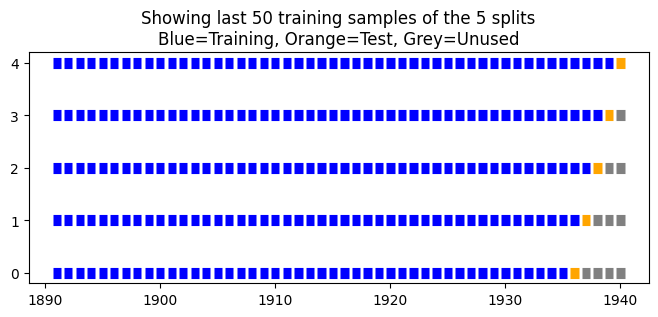

In [39]:
cutoff_values_for_cv = best_result.metrics["cutoff_values"]
test_size = best_result.config.get("test_size")
mse_per_split = best_result.metrics["mse_mean"]
df = ds.to_pandas()
cutoff_idxs = [np.where(df["ds"] == ct)[0][0] for ct in cutoff_values_for_cv]
colors = np.array(["blue", "orange", "grey"])

import matplotlib.pyplot as plt

show_last_n = 50

plt.figure(figsize=(8, 3))
for i, cutoff_idx in enumerate(cutoff_idxs):
    dataset_idxs = np.arange(len(df))[-show_last_n:]
    color_idxs = np.zeros_like(dataset_idxs)
    color_idxs[dataset_idxs > cutoff_idx] = 1
    color_idxs[dataset_idxs > cutoff_idx + test_size] = 2
    plt.scatter(x=dataset_idxs, y=np.ones_like(dataset_idxs) * i, c=colors[color_idxs], marker="_", lw=8)
plt.title(
    f"Showing last {show_last_n} training samples of the {len(cutoff_idxs)} splits\n"
    "Blue=Training, Orange=Test, Grey=Unused"
)
plt.show()

Let's visualize some predictions of the best model!

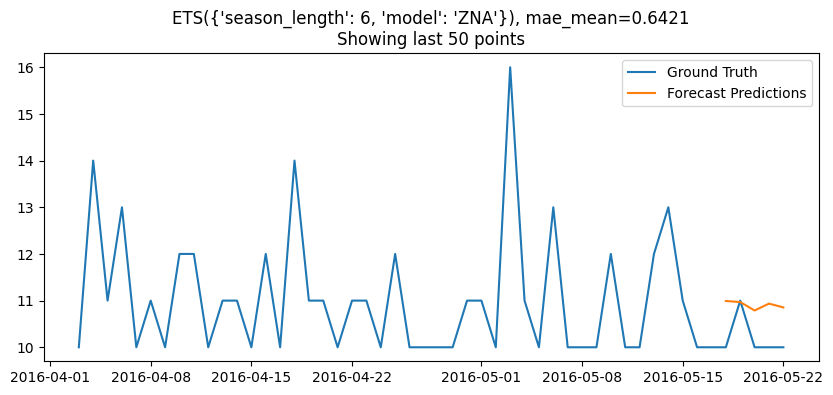

In [44]:
def plot_model_predictions(result, train_df):
    max_points_to_show = 50
    
    model_cls, model_params = result.config["model_cls_and_params"]
    checkpoint_dict = result.checkpoint.to_dict()
    forecast_df = checkpoint_dict["cross_validation_df"]
    plt.figure(figsize=(10, 4))
    # Only show the last 50 timesteps of the ground truth data
    plt.plot(
        train_df["ds"][-max_points_to_show:],
        train_df["y"][-max_points_to_show:],
        label="Ground Truth"
    )
    plt.plot(
        forecast_df["ds"],
        forecast_df[model_cls.__name__],
        label="Forecast Predictions"
    )
    plt.title(
        f"{model_cls.__name__}({model_params}), "
        f"mae_mean={result.metrics['mse_mean']:.4f}\n"
        f"Showing last {max_points_to_show} points"
    )
    plt.legend()

    plt.show()

plot_model_predictions(best_result, df)

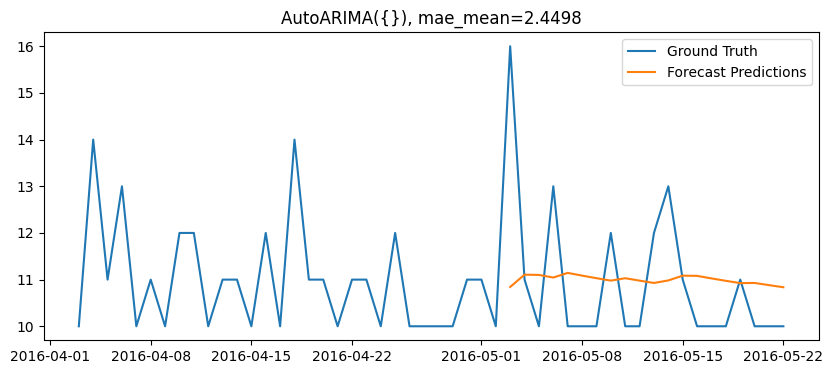

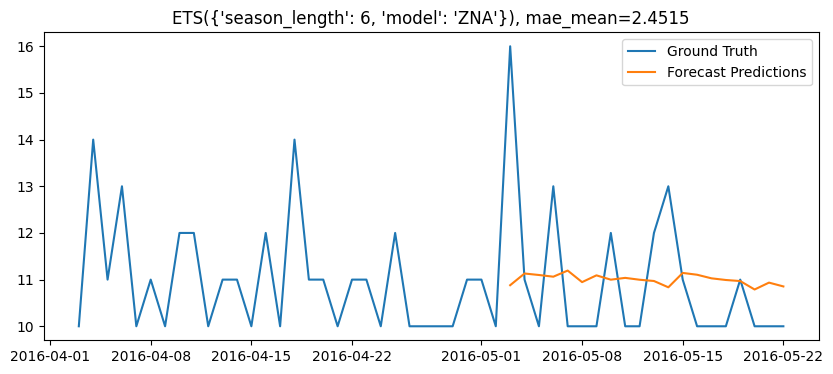

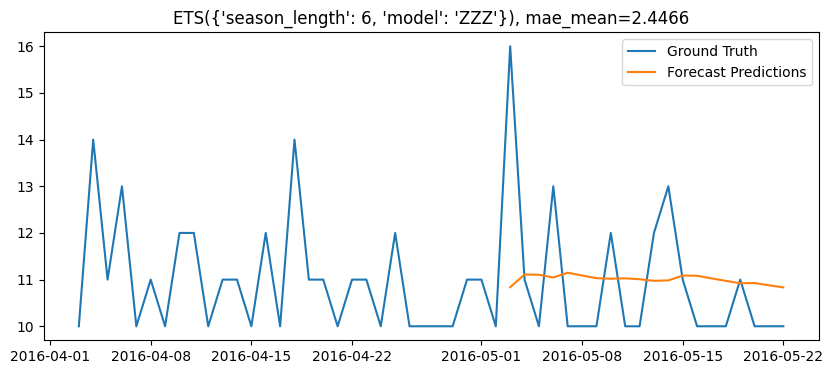

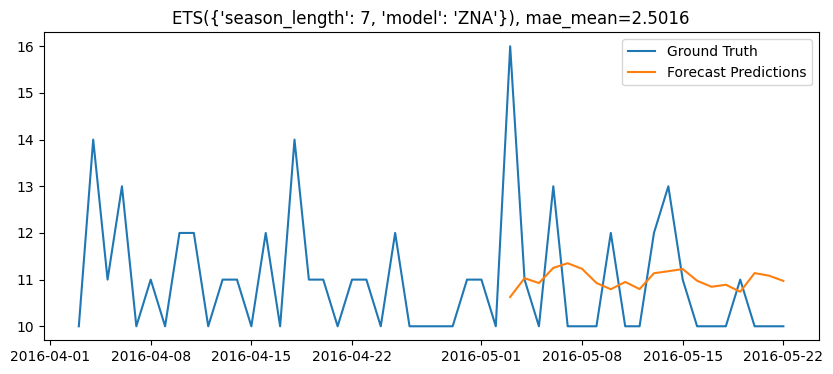

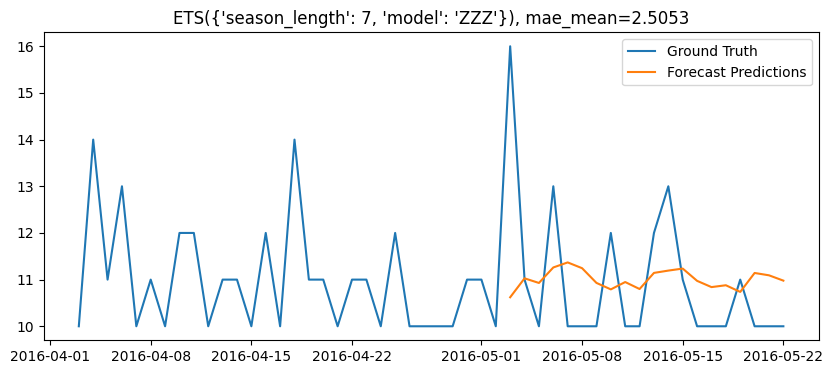

In [20]:
# Plot for all results
for result in result_grid:
    plot_model_predictions(result, df)